__this notebook__ trains a small LSTM language model and showcases its predicitons in javascript

In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3
!pip show numpy tensorflow subword_nmt nltk prefetch_generator tensorflowjs | grep -A1 Name
# note: we *need* tf2.2+, the code doesn't work on tf1.x

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

import nltk
import pandas as pd
import subword_nmt.learn_bpe, subword_nmt.apply_bpe
from tqdm import tqdm
from IPython.display import clear_output
from prefetch_generator import background  # pip install prefetch_generator
import matplotlib.pyplot as plt
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0,1,2,3
Name: numpy
Version: 1.18.2
--
Name: tensorflow
Version: 2.2.0
--
Name: subword-nmt
Version: 0.3.7
--
Name: nltk
Version: 3.5
--
Name: prefetch-generator
Version: 1.0.1
--
Name: tensorflowjs
Version: 2.1.0


#### Read the data

We're gonna train a model on arxiv papers based on [this dataset](https://www.kaggle.com/neelshah18/arxivdataset). We'll use the version of this dataset from [Yandex NLP course](https://github.com/yandexdataschool/nlp_course)

In [2]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'], axis=1).tolist()

tokenizer = nltk.tokenize.WordPunctTokenizer()
lines = [' '.join(line).lower() for line in tokenizer.tokenize_sents(lines)]
with open('lines.tok', 'w') as f:
    for line in lines:
        f.write(line + '\n')
        
with open('lines.tok', 'r') as f_lines_tok, open('bpe_rules', 'w') as f_bpe:
    subword_nmt.learn_bpe.learn_bpe(f_lines_tok, f_bpe, num_symbols=4000)
with open('bpe_rules', 'r') as f_bpe:
    bpeizer = subword_nmt.apply_bpe.BPE(f_bpe)
lines = list(map(' '.join, map(bpeizer.segment_tokens, map(str.split, lines))))
print(lines[0])

--2020-08-05 09:15:55--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2020-08-05 09:15:56--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc53f33f2a074d99f985994595d.dl.dropboxusercontent.com/cd/0/get/A824sc_B_ysOFhi9yvGJVbno7uQGtB6LXL3NSnWTsCM1d8nU39SYYp_GO6MOnBPKi10wCDvdla6UtXKyrPOLgfJcDcArG5B4VHwwFkJgW1ovEg/file?dl=1# [following]
--2020-08-05 09:15:56--  https://ucc53f33f2a074d99f985994595d.dl.dropboxusercontent.com/cd/0/get/A824sc_B_ysOFhi9yvGJVbno7uQGtB6LXL3NSnWTsCM1d8nU39SYYp_GO6MOnBPKi10wCDvdla6UtXKyrPOLgfJcDcArG5B4VHwwFkJ

90-th percentile: 333


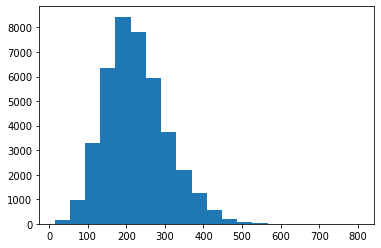

In [3]:
num_tokens_per_line = list(map(len, map(str.split, lines)))
max_len = int(np.percentile(num_tokens_per_line, 90))
plt.hist(num_tokens_per_line, bins=20);
print("90-th percentile:", max_len)

#### Vocabulary

Let's define a special class that converts between text lines and tf tensors

In [5]:
import nltk
import json
from collections import Counter

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        source: https://github.com/yandexdataschool/nlp_course/blob/2019/week04_seq2seq/utils.py
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @classmethod
    def from_data(cls, lines, max_tokens=None, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens, counts = zip(*Counter(flat_lines).most_common(max_tokens))
        tokens = [bos, eos, unk] + [t for t in sorted(tokens) if t not in (bos, eos, unk)]
        return cls(tokens, bos, eos, unk)
    
    def save(self, path):
        with open(path, 'w') as f:
            json.dump((self.tokens, self.bos, self.eos, self.unk), f)
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            return cls(*json.load(f))

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print( as_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))
        matrix = np.full((len(lines), max_len), self.eos_ix, dtype='int32')
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = row_ix

        return tf.convert_to_tensor(matrix)

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def infer_length(self, batch_ix: tf.Tensor, dtype=tf.int32):
        """ compute length given output indices, return int32 vector [len(batch_ix)] """
        is_eos = tf.cast(tf.equal(batch_ix, self.eos_ix), dtype)
        count_eos = tf.cumsum(is_eos, axis=1, exclusive=True)
        lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), dtype), axis=1)
        return lengths


    def infer_mask(self, batch_ix: tf.Tensor, dtype=tf.bool):
        """ all tokens after (but not including) first EOS are masked out """
        lengths = self.infer_length(batch_ix)
        return tf.sequence_mask(lengths, maxlen=tf.shape(batch_ix)[1], dtype=dtype)

In [7]:
voc = Vocab.from_data(lines)
voc.to_matrix(lines[:2])

<tf.Tensor: shape=(2, 149), dtype=int32, numpy=
array([[   0, 1193, 3039,  445, 3885, 1589, 4000, 2981,  314,   87, 4025,
        2924,  285,  358, 1589, 3930, 2962, 4045, 3925, 2080, 3039, 2152,
        3758, 1674, 4000,  299, 3675,  445,   41, 3681, 2355,  690, 2045,
        2576, 3681, 2925, 3039,  445, 3885, 2581,  113, 3161, 2088, 1262,
        2576, 4000,  299, 3675, 1532,  299, 1282, 3681, 2408, 3758, 3016,
        3079,  542, 3309, 2714, 2576, 3681, 1879,  299, 2981,   41, 2661,
        3370, 2408, 2672, 3681, 1568, 2782, 4062, 2493, 2592, 3681, 3930,
        2962,   51,   41,   47,  977,   35, 2751, 4069, 2297, 3758, 3681,
         962, 3482,   37, 2576,   37, 3681,   37,  379, 1319, 2408,   41,
        4025,  264, 1446, 4067, 3099, 1954,  445, 2345, 1905, 2654, 3482,
          37, 2576,   37, 3681,   37,  379, 2413, 4067, 2661, 1889,  299,
        3329, 1921,  140,   41, 1905,  577,  649,   35, 2661, 3039,  445,
        2344, 1903, 2747, 1905, 3633, 3120, 3294, 2624, 3078, 30

In [8]:
voc.to_lines(voc.to_matrix(lines[:3])[:, :15])

['dual recurrent attention units for visual question answering ; we propose an architecture for',
 'sequential short - text classification with recurrent and convolutional neural networks ; recent approaches',
 'multi@@ resolution recurrent neural networks : an application to dialogue response generation ; we']

### Model & training
Now let as train a simple LSTM language model the pre-processed data.

__Note:__ we don't use validation for simplicity's sake, meaning our model probably overfits like crazy. But who cares? its a demo!

In [65]:
class LanguageModel(keras.models.Model):
    def __init__(self, voc, emb_size=128, hid_size=1024):
        super().__init__()
        self.voc = voc
        self.emb = L.Embedding(len(voc), emb_size)
        self.lstm = L.LSTM(hid_size, return_sequences=True, return_state=True)
        self.logits = L.Dense(len(voc))
        
    def call(self, batch_ix):
        hid_seq, last_hid, last_cell = self.lstm(self.emb(batch_ix[:, :-1]))
        logits = self.logits(hid_seq)
        mask = self.voc.infer_mask(batch_ix, dtype=tf.float32)
        
        loss_values = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=tf.reshape(logits, [-1, logits.shape[-1]]),
            labels=tf.reshape(batch_ix[:, 1:], [-1])
        )
        mean_loss = tf.reduce_sum(loss_values * tf.reshape(mask[:, 1:], tf.shape(loss_values))) \
                  / tf.reduce_sum(mask[:, 1:])
        return mean_loss


def iterate_minibatches(lines, batch_size, cycle=True, **kwargs):
    while True:
        lines_shuf = [lines[i] for i in np.random.permutation(len(lines))]
        for batch_start in range(0, len(lines_shuf), batch_size):
            yield (voc.to_matrix(lines_shuf[batch_start: batch_start + batch_size], **kwargs),) * 2
        if not cycle:
            break


In [66]:
with tf.distribute.MirroredStrategy().scope() as scope:
    print('Number of devices: {}'.format(scope.num_replicas_in_sync))
    model = LanguageModel(voc)
    model.compile(optimizer='adam', loss=lambda _, loss: tf.reduce_mean(loss))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [67]:
import glob
checkpoint_path = './checkpoints/lstm1024_emb128_bpe4000_batch256'

if glob.glob(checkpoint_path + '*'):
    print("Loading pre-trained model.")
    model.load_weights(checkpoint_path)
else:
    print("Training from scratch")
    model.fit(iterate_minibatches(lines, batch_size=256, max_len=max_len), 
              epochs=100, steps_per_epoch=256,
              callbacks=[keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss')])

Loading pre-trained model.


### Make JS-compatible language model applier

In [286]:
# custom keras model that
# * applies a single step of LSTM
# * uses pure keras, no custom python code

l_prev_tokens = L.Input([None], dtype='int32')
l_prev_hid = L.Input([model.lstm.units], dtype='float32', name='previous_lstm_hid')
l_prev_cell = L.Input([model.lstm.units], dtype='float32', name='previous_lstm_cell')

l_prev_emb = model.emb(l_prev_tokens)  # [batch, emb_size]
_, l_new_hid, l_new_cell = model.lstm(l_prev_emb, initial_state=[l_prev_hid, l_prev_cell])
l_new_logits = model.logits(l_new_hid)

model_step = keras.models.Model([l_prev_tokens, l_prev_hid, l_prev_cell],
                                [l_new_logits, l_new_hid, l_new_cell])
tfjs.converters.save_keras_model(model_step, './lm')

/home/jheuristic/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [320]:
# test model step from python
h = c = tf.ones([1, model.lstm.units])
model_step((tf.convert_to_tensor([[3]], dtype='int32'), h, c))

[<tf.Tensor: shape=(1, 4164), dtype=float32, numpy=
 array([[ 1.4643092 , -1.8286911 ,  1.2862148 , ...,  0.52897644,
          1.7882657 ,  2.1528049 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[ 5.3198510e-01,  1.5283672e-10, -7.6133746e-01, ...,
          4.6707136e-03,  6.1378783e-01,  5.0298193e-05]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[ 0.7669934 ,  0.00931896, -0.9993891 , ...,  0.04036063,
          0.7149762 ,  1.000839  ]], dtype=float32)>]

In [328]:
# save bpe and vocabulary
with open('./frontend/voc.json', 'w') as f:
    packed_bpe_rules = list(map(list, sorted(bpeizer.bpe_codes.keys(), key=bpeizer.bpe_codes.get)))
    json.dump([model.lstm.units, model.emb.output_dim, model.logits.units,
               packed_bpe_rules, voc.tokens, voc.bos, voc.eos, voc.unk], f)

In [314]:
voc.to_matrix(['deep neural'])[:, :-1].shape

TensorShape([1, 3])